## Data Enhancement and Augmentation Techniques for Oculomotoric Biometric Identification using DeepEye

In [1]:
import os
import socket

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

Populating the interactive namespace from numpy and matplotlib
gpu03


In [2]:
import joblib
import numpy as np
import random
from Evaluation import evaluation
import sys
import seaborn as sns
from tqdm.notebook import tqdm

## Download the data
* the data can be found here: 
    * Data/test_data.npz https://osf.io/g8rvb/download
    * Data/train_data.npz https://osf.io/s7vay/download
* the file structure should look like this:
    * Data/
    * ├── test_data.npz
    * └── train_data.npz

In [3]:
if not os.path.exists('Data/'):
    os.makedirs('Data/')
if not os.path.exists('Data/test_data.npz'):
    !wget -O Data/test_data.npz https://osf.io/g8rvb/download
if not os.path.exists('Data/train_data.npz'):
    !wget -O Data/train_data.npz https://osf.io/s7vay/download
        
if not os.path.exists('trained_models/'):
    os.makedirs('trained_models/')

## Set up the GPU you want to train on
* if you want to train on Google-Colab or the CPU you don't need to specify the GPU

In [4]:
flag_train_on_gpu = True
GPU = 0
if flag_train_on_gpu:
    import tensorflow as tf
    # select graphic card
    os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    tf_session = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2



## Load the data and the parameter for the model

In [5]:
Y_columns = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

train_data = np.load('Data/train_data.npz')
test_data = np.load('Data/test_data.npz')
X_train = train_data['X_train']
Y_train = train_data['Y_train']
X_test = test_data['X_test']
Y_test = test_data['Y_test']

In [ ]:
# if you are running the notebook on Google-Colab or you don't have enough RAM 
# you can reduce the number of training/test samples by using only a subset
# of all sessions. In total there are 4 sessions (1,2,3,4). Uncomment the
# lines below to use only the first 2 sessions and the first 77 seqIDs


sessions_use = [1.,2.]
seq_ids_use = np.arange(1,78,1)

train_ids = np.isin(Y_train[:,Y_columns['session']], sessions_use)
test_ids  = np.isin(Y_test[:,Y_columns['session']], sessions_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]

train_ids = np.isin(Y_train[:,Y_columns['seqId']], seq_ids_use)
test_ids  = np.isin(Y_test[:,Y_columns['seqId']], seq_ids_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]

In [ ]:
batch_size = 64
# if the batch_size is too high for your GPU/CPU uncomment the following line
#batch_size = 32

### Show example instances of the data

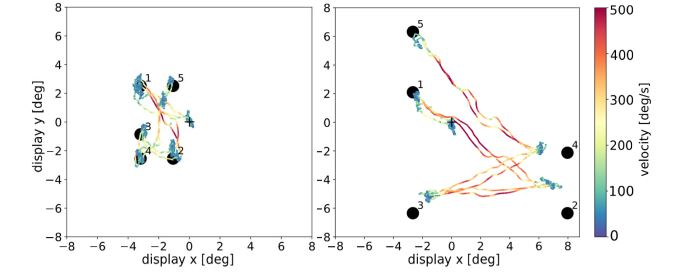

In [6]:
from IPython.display import Image
Image(filename='images/scanpaths.jpg')

## Apply the Data Augmentation/Enhancement
* Here you should implement your own data augmentation/enhancement
* implement the function 'transform(X_train,Y_train,Y_columns)' in 'DataAugmentation/data_augmentation.py'

In [7]:
from DataAugmentation import data_augmentation
X_train_augmented,Y_train_augmented = data_augmentation.transform(X_train,Y_train,Y_columns)

## Train model and get embeddings

In [8]:
embeddings_concatenated_augmented = evaluation.evaluate_create_test_embeddings(X_train_augmented,
                                                                               Y_train_augmented,
                                                                               X_test,Y_test,
                                                                               Y_columns,
                                                                               batch_size = batch_size)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
98/98 [==============================] - 16s 73ms/step - loss: 2.4728 - accuracy: 0.2754 - val_loss: 5.8320 - val_accuracy: 0.0617
Epoch 2/100
98/98 [==============================] - 6s 59ms/step - loss: 1.2376 - accuracy: 0.5748 - val_loss: 3.8569 - val_accuracy: 0.2545
Epoch 3/100
98/98 [==============================] - 6s 61ms/step - loss: 0.8899 - accuracy: 0.6889 - val_loss: 3.1639 - val_accuracy: 0.4554
Epoch 4/100
98/98 [==============================] - 5s 56ms/step - loss: 0.7268 - accuracy: 0.7611 - val_loss: 2.4253 - val_accuracy: 0.4993
Epoch 5/100
98/98 [==============================] - 5s 55ms/step - loss: 0.5879 - accuracy: 0.8036 - val_loss: 0.9702 - val_accuracy: 0.7205
Epoch 6/100
98/98 [==============================] - 6s 63ms/step - loss: 0.4179 - accuracy: 0.8598 - val_loss: 1.5851 - val_accuracy: 0.6366
Epoch 7/100
98/98 [==============================] - 6s 59ms/step - loss: 0.4008 - accuracy: 0.8714 - val_loss: 1.0990 - val_accuracy: 0.7186
Epoch

98/98 [==============================] - 6s 63ms/step - loss: 0.0735 - accuracy: 0.9783 - val_loss: 0.4310 - val_accuracy: 0.8853
Epoch 30/100
98/98 [==============================] - 6s 58ms/step - loss: 0.0758 - accuracy: 0.9786 - val_loss: 0.3151 - val_accuracy: 0.9147
Epoch 31/100
98/98 [==============================] - 5s 46ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.4153 - val_accuracy: 0.8935
Epoch 32/100
98/98 [==============================] - 6s 61ms/step - loss: 0.1279 - accuracy: 0.9587 - val_loss: 0.6771 - val_accuracy: 0.8323
Epoch 33/100
98/98 [==============================] - 6s 58ms/step - loss: 0.0827 - accuracy: 0.9754 - val_loss: 0.4851 - val_accuracy: 0.8689
Epoch 34/100
98/98 [==============================] - 5s 47ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.3818 - val_accuracy: 0.9002
Epoch 35/100
98/98 [==============================] - 5s 51ms/step - loss: 0.0405 - accuracy: 0.9889 - val_loss: 0.4294 - val_accuracy: 0.9012
Epoch 36/100

98/98 [==============================] - 3s 35ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1258 - val_accuracy: 0.9653
Epoch 40/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1255 - val_accuracy: 0.9653
Epoch 41/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1257 - val_accuracy: 0.9658
Epoch 42/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.9663
Epoch 43/100
98/98 [==============================] - 4s 36ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.9658
Epoch 44/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1257 - val_accuracy: 0.9643
Epoch 45/100
98/98 [==============================] - 3s 34ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1253 - val_accuracy: 0.9658
Epoch 46/100

In [9]:
embeddings_concatenated_baseline = evaluation.evaluate_create_test_embeddings(X_train,
                                                                              Y_train,
                                                                              X_test,
                                                                              Y_test,
                                                                              Y_columns,
                                                                              batch_size = batch_size)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
487/487 [==============================] - 35s 58ms/step - loss: 3.8493 - accuracy: 0.0833 - val_loss: 5.2829 - val_accuracy: 0.1090
Epoch 2/100
487/487 [==============================] - 28s 59ms/step - loss: 2.6456 - accuracy: 0.2561 - val_loss: 3.4167 - val_accuracy: 0.2279
Epoch 3/100
487/487 [==============================] - 28s 57ms/step - loss: 2.1523 - accuracy: 0.3688 - val_loss: 2.2154 - val_accuracy: 0.3653
Epoch 4/100
487/487 [==============================] - 29s 60ms/step - loss: 1.8047 - accuracy: 0.4600 - val_loss: 2.5652 - val_accuracy: 0.3457
Epoch 5/100
487/487 [==============================] - 27s 54ms/step - loss: 1.5516 - accuracy: 0.5361 - val_loss: 1.6158 - val_accuracy: 0.5218
Epoch 6/100
487/487 [==============================] - 28s 58ms/step - loss: 1.2587 - accuracy: 0.6157 - val_loss: 1.2933 - val_accuracy: 0.6133
Epoch 7/100
487/487 [==============================] - 27s 55ms/step - loss: 1.0207 - accuracy: 0.6847 - val_loss: 1.4022 - val_ac

487/487 [==============================] - 25s 52ms/step - loss: 0.1437 - accuracy: 0.9516 - val_loss: 0.7180 - val_accuracy: 0.8195
Epoch 28/100
487/487 [==============================] - 25s 51ms/step - loss: 0.1103 - accuracy: 0.9637 - val_loss: 0.8821 - val_accuracy: 0.7975
Epoch 29/100
487/487 [==============================] - 27s 55ms/step - loss: 0.1343 - accuracy: 0.9546 - val_loss: 0.8888 - val_accuracy: 0.7901
Epoch 30/100
487/487 [==============================] - 26s 53ms/step - loss: 0.1126 - accuracy: 0.9628 - val_loss: 0.8249 - val_accuracy: 0.8024
Epoch 31/100
487/487 [==============================] - 27s 54ms/step - loss: 0.1253 - accuracy: 0.9589 - val_loss: 0.8324 - val_accuracy: 0.8053
Epoch 32/100
487/487 [==============================] - 26s 52ms/step - loss: 0.0915 - accuracy: 0.9698 - val_loss: 1.1112 - val_accuracy: 0.7650
Epoch 33/100
487/487 [==============================] - 26s 54ms/step - loss: 0.1128 - accuracy: 0.9607 - val_loss: 0.7758 - val_accuracy

In [10]:
num_sessions = len(np.unique(Y_test[:,Y_columns['session']]))
print('number of sessions: ' + str(num_sessions))

number of sessions: 2


## Plot results

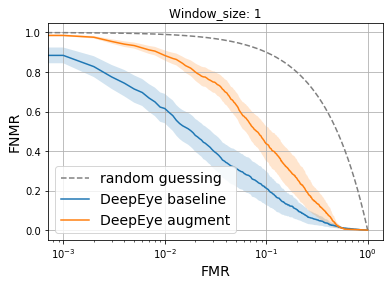

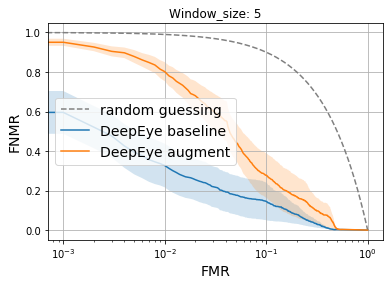

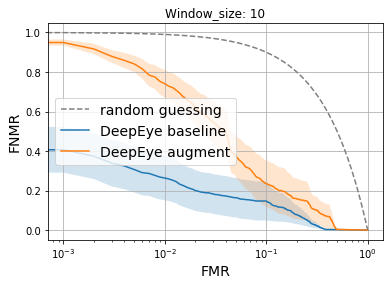

In [11]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 1
n_impostors = 24
n_enrollment_sessions = num_sessions -1
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'verification')
    plt.show()

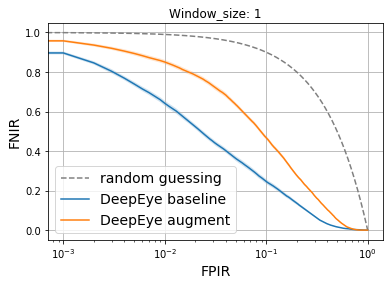

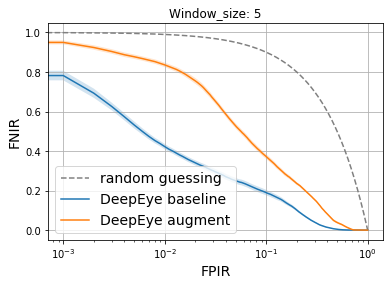

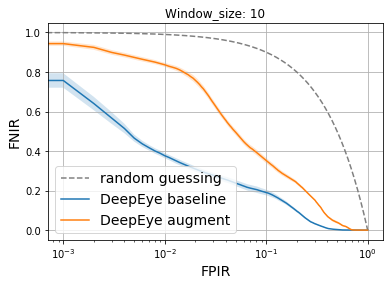

In [12]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 20
n_impostors = 5
n_enrollment_sessions = num_sessions -1
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'identification')
    plt.show()